In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from datetime import datetime
from dataclasses import dataclass

pd.set_option('display.max_columns', 30)

# suppress seaborn warnings
warnings.filterwarnings('ignore', category=FutureWarning)

%matplotlib inline

In [2]:
@dataclass
class Stock:
    ticker: str
    df: pd.DataFrame
    x: int
    y: int

    def print_tail(self):
        print(self.ticker)
        print(self.df.tail(2))

In [3]:
# Load Data
TICKERS = ['SCHD', 'SCHG', 'SCHX', 'VOO']
AXES = [(0,0), (0,1), (1,0), (1,1)]

NOW = datetime.now()
START = datetime(NOW.year - 1, NOW.month, NOW.day)

stocks: list[Stock] = []
for ticker, (x, y) in zip(TICKERS, AXES):
    colnames = [x.lower() for x in pd.read_csv(f'{ticker}_alpha_vantage_data.csv', nrows=1).columns]
    df = pd.read_csv(f'{ticker}_alpha_vantage_data.csv', index_col='date', parse_dates=True, names = colnames, skiprows=1)
    stocks.append(Stock(ticker, df, x, y))
    
schd = stocks[0]
schg = stocks[1]
schx = stocks[2]
voo = stocks[3]

### Useful Functions

In [4]:
def print_tails(investments: list[Stock]):
    for i in investments:
        i.print_tail()

In [5]:
# Make all dfs the same length
min_length = min([len(stock.df) for stock in stocks])
for stock in stocks:
    length = len(stock.df)
    stock.df = stock.df.iloc[:min_length]
    print(f'Chopped Off {length - min_length} days from {stock.ticker}')
    

Chopped Off 0 days from SCHD
Chopped Off 454 days from SCHG
Chopped Off 494 days from SCHX
Chopped Off 282 days from VOO


In [6]:
# Get single year for dfs
for stock in stocks:
    original_length = len(stock.df)
    stock.df = stock.df.loc[:START]
    new_length = len(stock.df)
    print(f'Chopped Off {original_length - new_length} days from {stock.ticker}')


Chopped Off 2741 days from SCHD
Chopped Off 2741 days from SCHG
Chopped Off 2741 days from SCHX
Chopped Off 2741 days from VOO


In [7]:
# Add moving average columns
moving_averages = [3, 7, 30, 90, 180, 360, 360 * 3, 360 * 5]

for stock in stocks:
    for days in moving_averages:
        column_name = f'ma_{days}'
        rolling = stock.df['close'].rolling(window=pd.Timedelta(days=days)).mean()
        stock.df.loc[:, column_name] = rolling.values

In [8]:
# Add percent change columns
changes = [-90, -60, -30, -7, -3, -1, 1, 3, 7, 30, 60, 90]
for change in changes:
    for stock in stocks:
        column_name = f'pct_change_{change}'
        percent_change = stock.df['close'].pct_change(change)
        stock.df.loc[:, column_name] = percent_change.values

## Closing Price

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

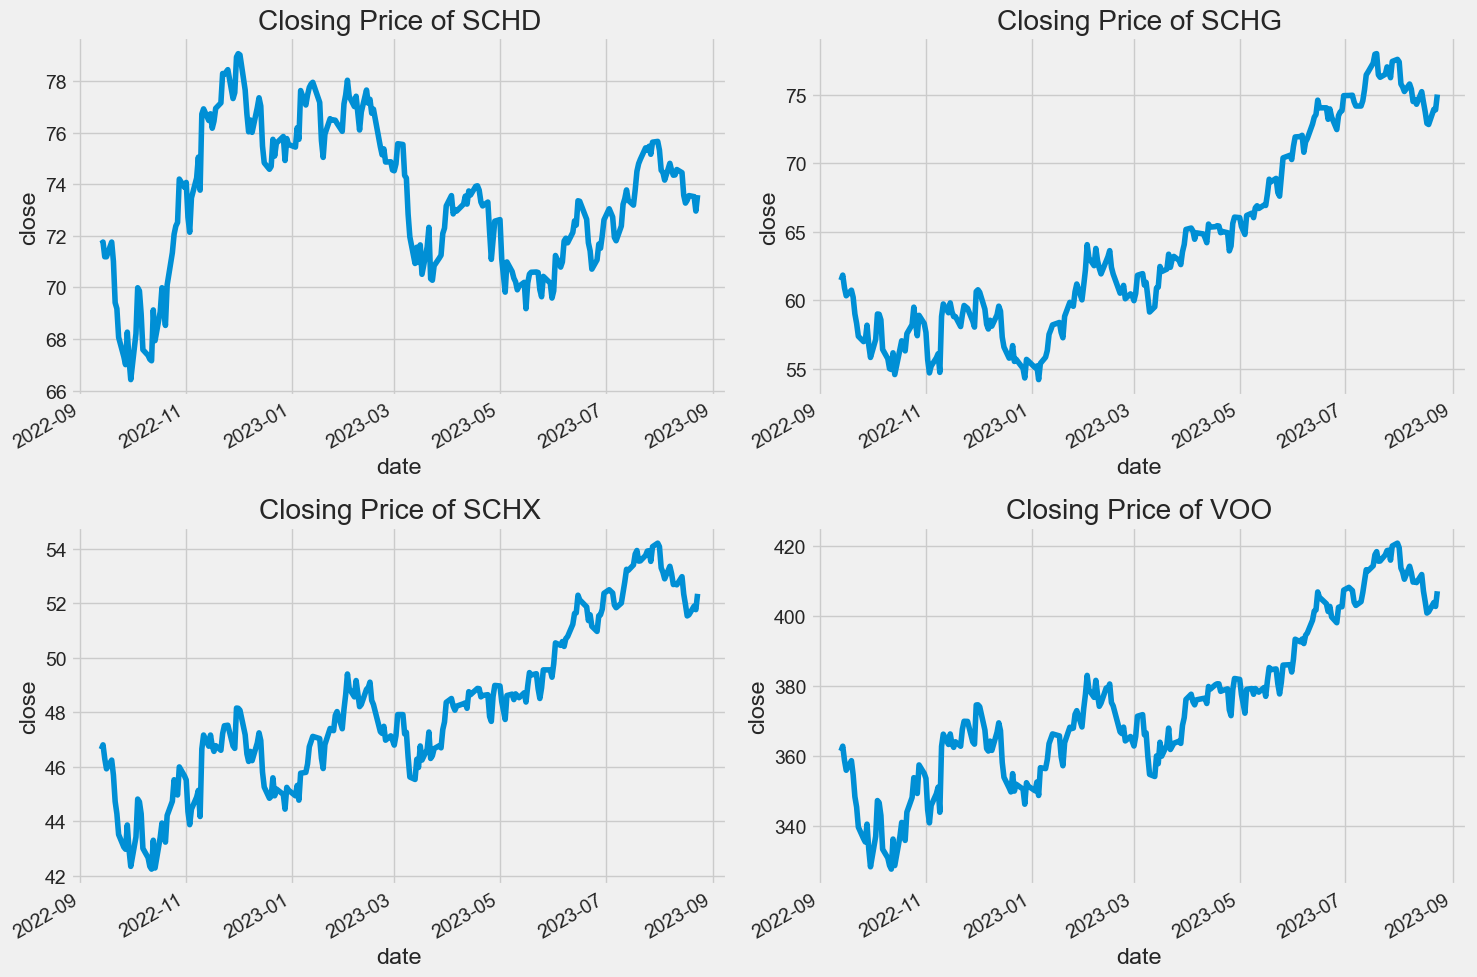

In [9]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, i)
    stock.df['close'].plot()
    plt.ylabel('close')
    plt.xlabel('date')
    plt.title(f"Closing Price of {stock.ticker}")

plt.tight_layout()
plt.show()

## Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

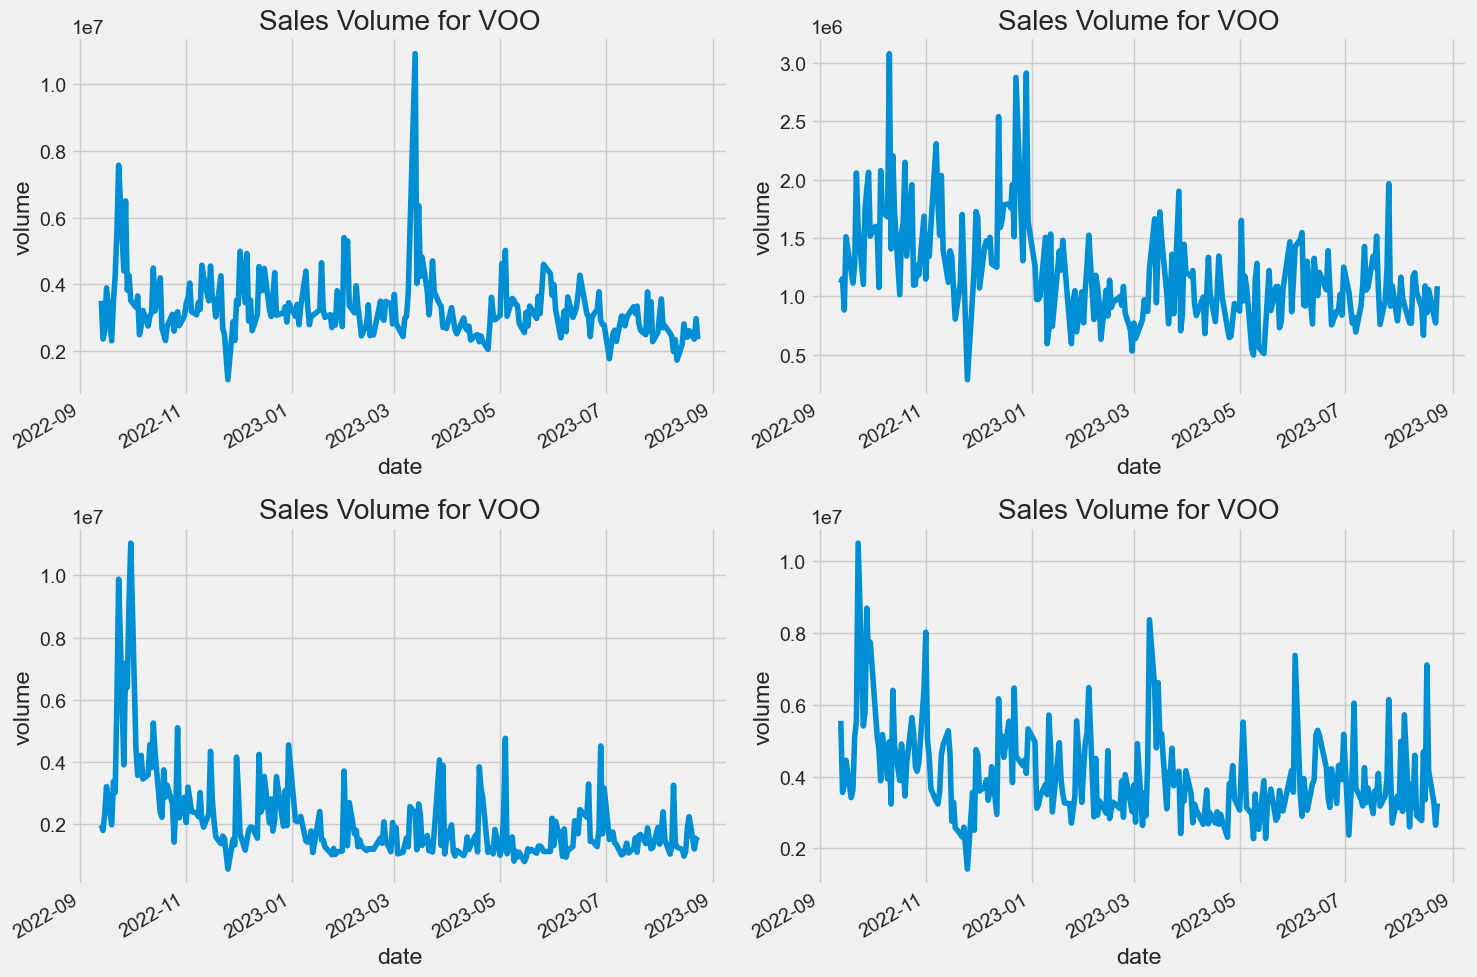

In [10]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, i)
    stock.df['volume'].plot()
    plt.ylabel('volume')
    plt.xlabel('date')
    plt.title(f"Sales Volume for {ticker}")
    
plt.tight_layout()

Now that we've seen the visualizations for the closing price and the volume traded each day, let's go ahead and calculate the moving average for the stock.

# 2. What was the moving average of the various stocks?

The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

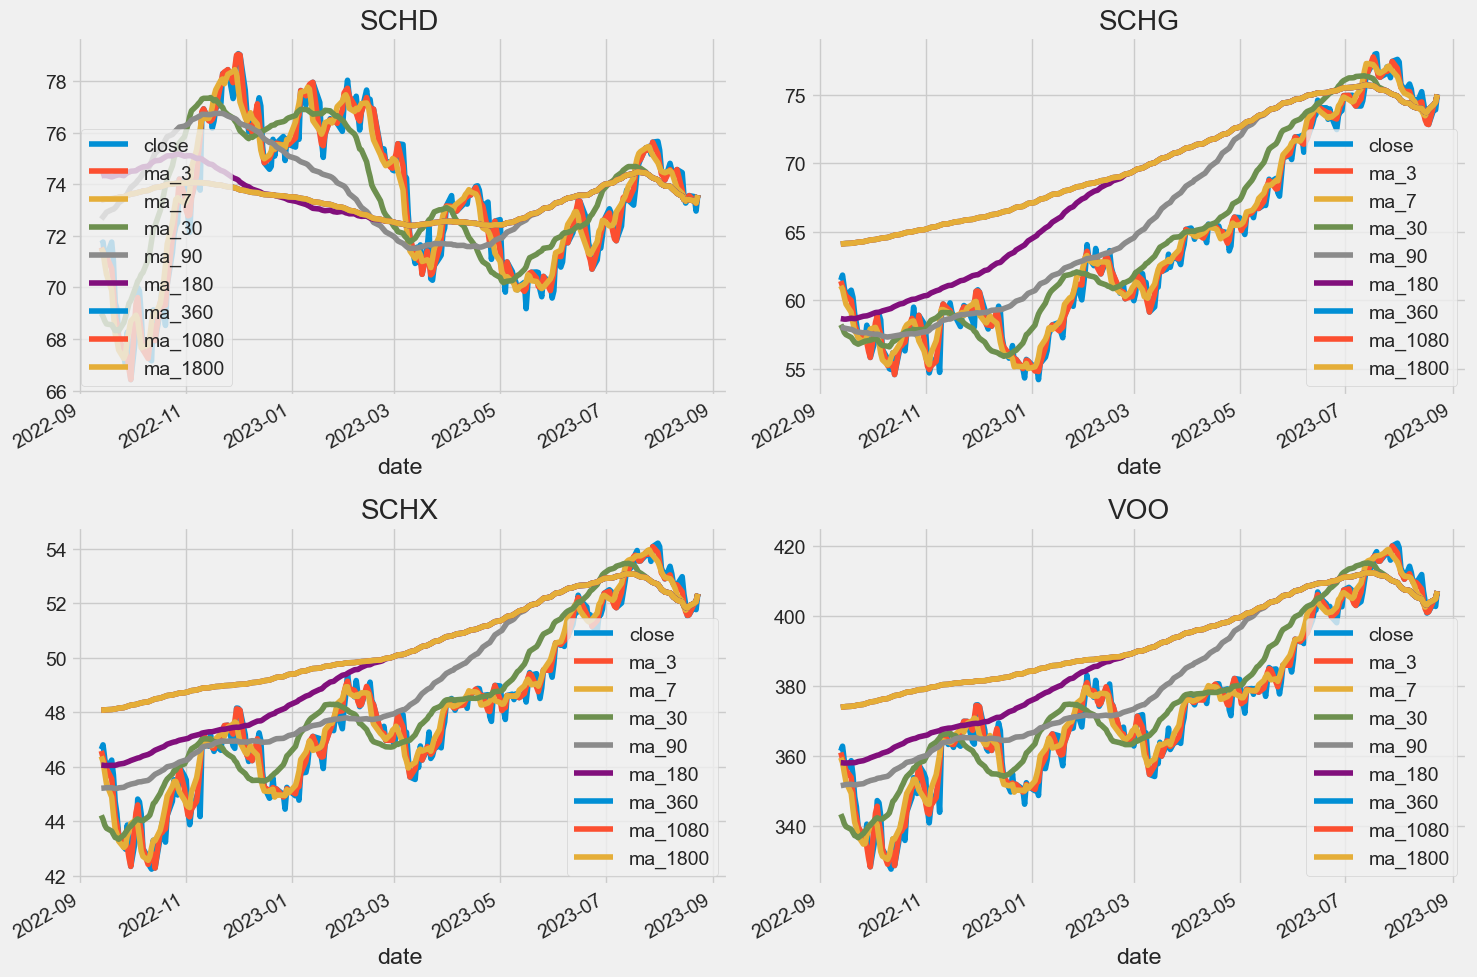

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

for stock in stocks:
    moving_average_columns = [col for col in stock.df.columns if 'ma' in col]
    plot_columns = ['close'] + moving_average_columns
    stock.df[plot_columns].plot(ax=axes[stock.x, stock.y])
    axes[stock.x, stock.y].set_title(stock.ticker)

fig.tight_layout()

# 3. What was the daily return of the stock on average?

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve the daily returns for the Apple stock.

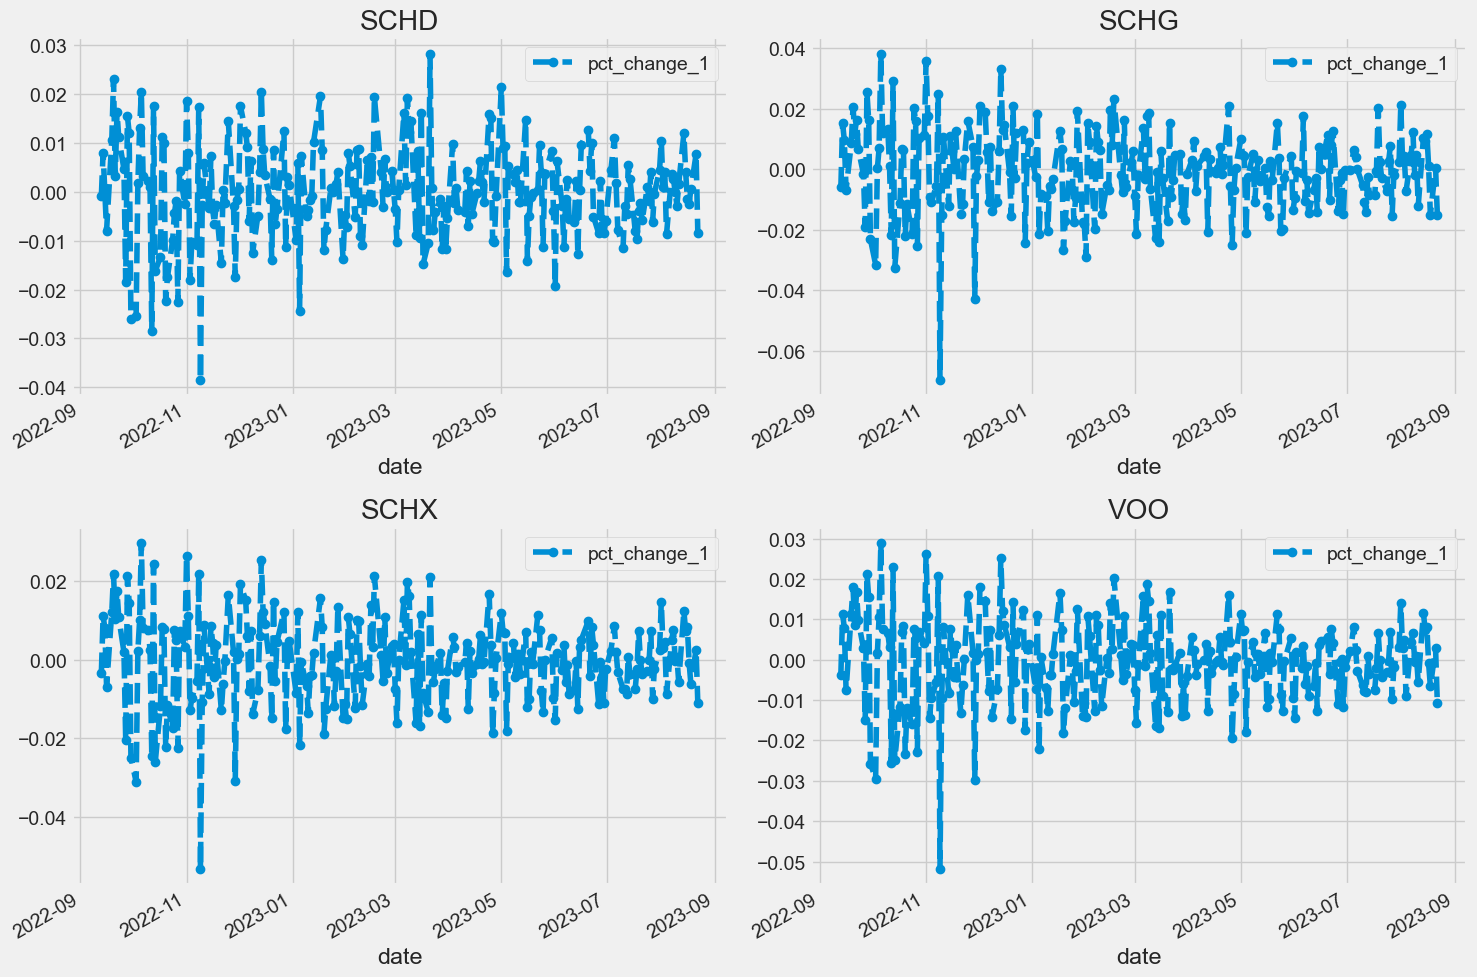

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
for stock in stocks:
    stock.df['pct_change_1'].plot(ax=axes[stock.x, stock.y], legend=True, linestyle='--', marker='o')
    axes[stock.x, stock.y].set_title(stock.ticker)

fig.tight_layout()

Great, now let's get an overall look at the average daily return using a histogram. We'll use seaborn to create both a histogram and kde plot on the same figure.

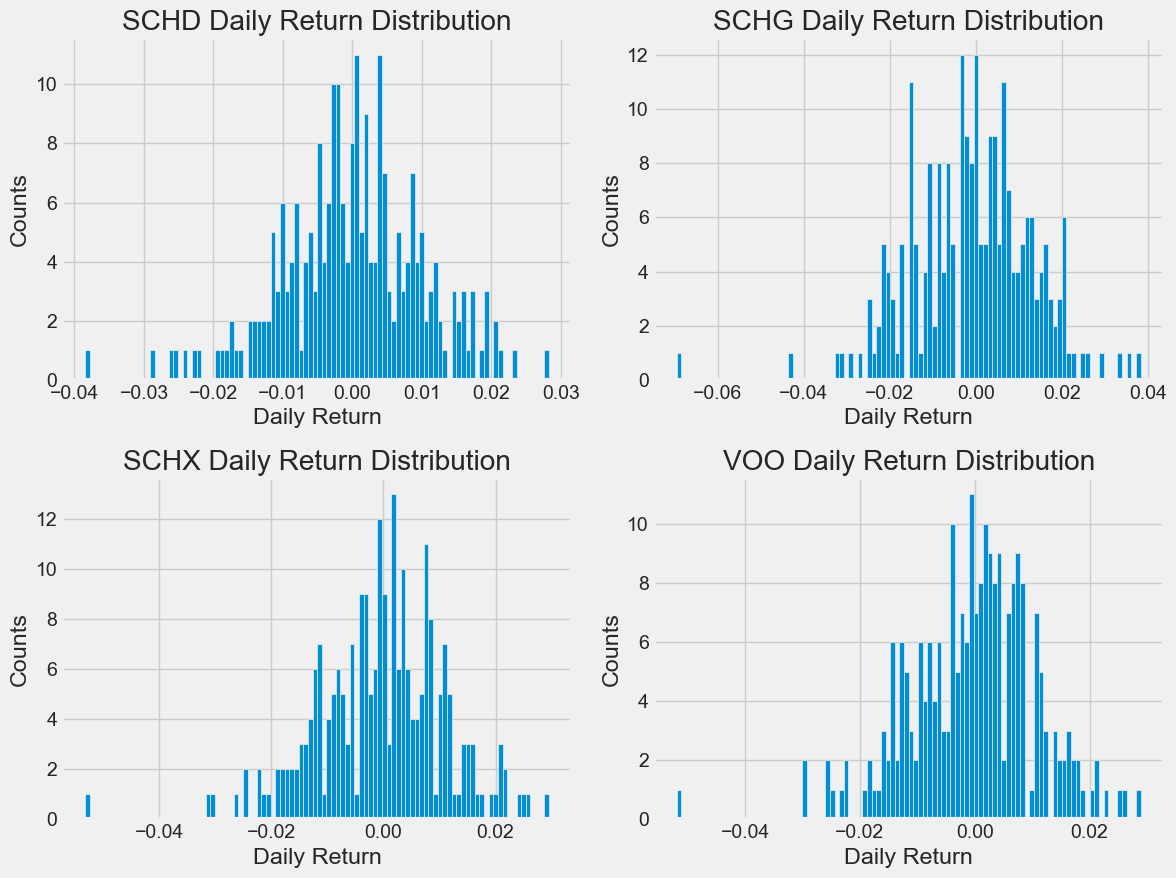

In [13]:
plt.figure(figsize=(12, 9))

for i, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, i)
    stock.df['pct_change_1'].hist(bins=100)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{stock.ticker} Daily Return Distribution')
    
plt.tight_layout()

# 4. What was the correlation between different stocks closing prices?

Correlation is a statistic that measures the degree to which two variables move in relation to each other which has a value that must fall between -1.0 and +1.0. Correlation measures association, but doesn’t show if x causes y or vice versa — or if the association is caused by a third factor[1].

Now what if we wanted to analyze the returns of all the stocks in our list? Let's go ahead and build a DataFrame with all the ['Close'] columns for each of the stocks dataframes.

Now we can compare the daily percentage return of two stocks to check how correlated. First let's see a sotck compared to itself.

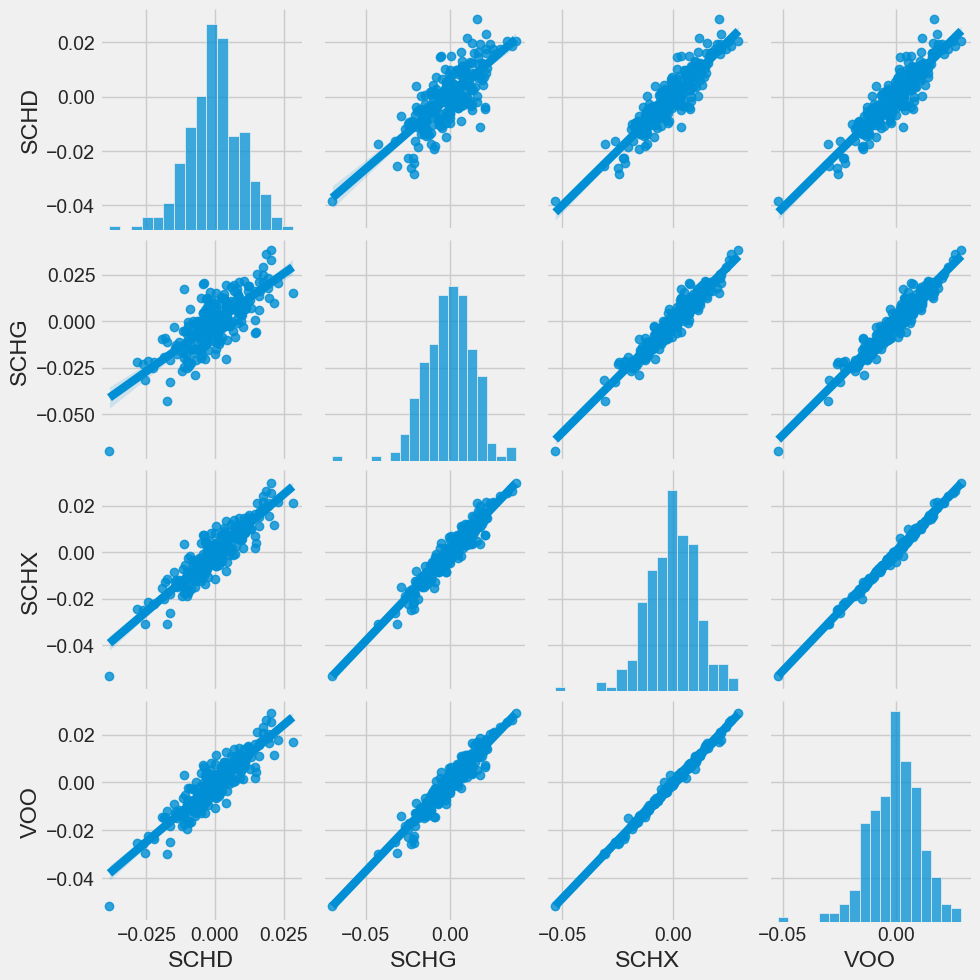

In [15]:
pct_change_1 = pd.concat([stock.df['pct_change_1'] for stock in stocks], axis=1, keys=TICKERS)
closing = pd.concat([stock.df['close'] for stock in stocks], axis=1, keys=TICKERS)
sns.pairplot(data=pct_change_1, kind='reg')

Above we can see all the relationships on daily returns between all the stocks. A quick glance shows an interesting correlation between Google and Amazon daily returns. It might be interesting to investigate that individual comparison. 

While the simplicity of just calling `sns.pairplot()` is fantastic we can also use `sns.PairGrid()` for full control of the figure, including what kind of plots go in the diagonal, the upper triangle, and the lower triangle. Below is an example of utilizing the full power of seaborn to achieve this result.

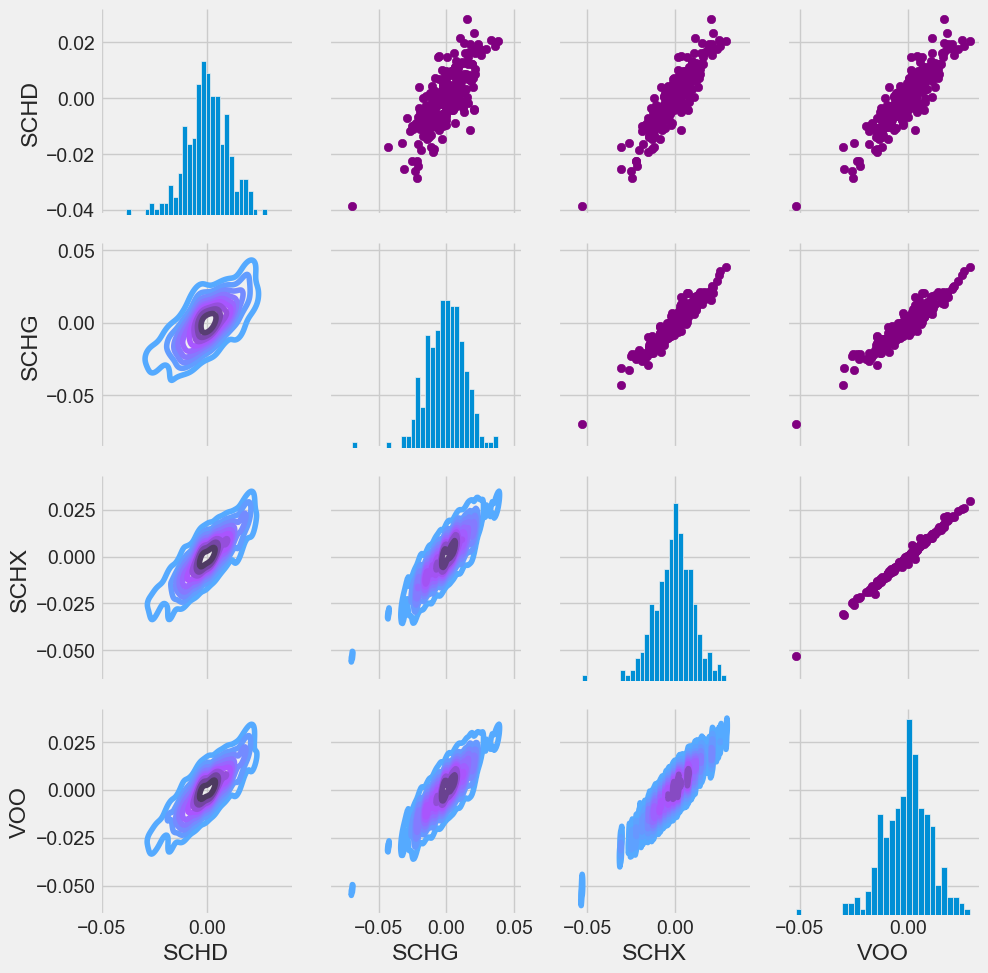

In [16]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(pct_change_1)

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

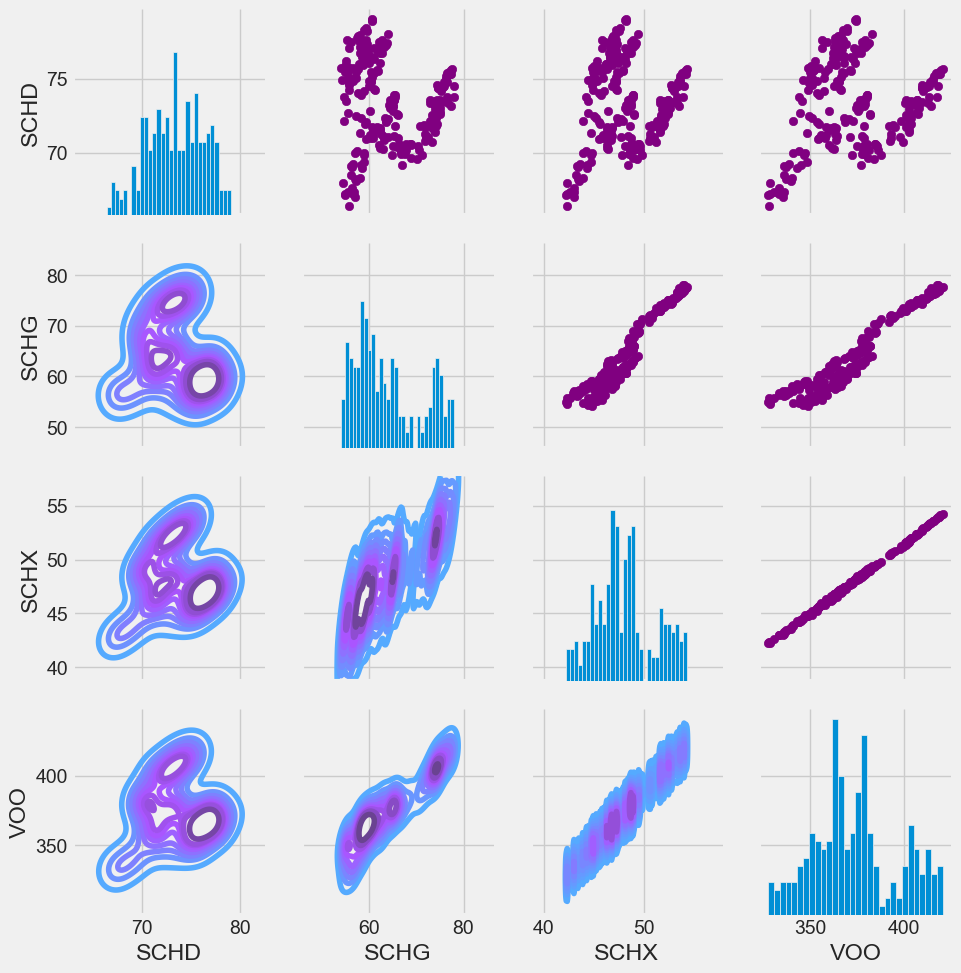

In [17]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist, bins=30)

Finally, we could also do a correlation plot, to get actual numerical values for the correlation between the stocks' daily return values. By comparing the closing prices, we see an interesting relationship between Microsoft and Apple.

Text(0.5, 1.0, 'Correlation of stock closing price')

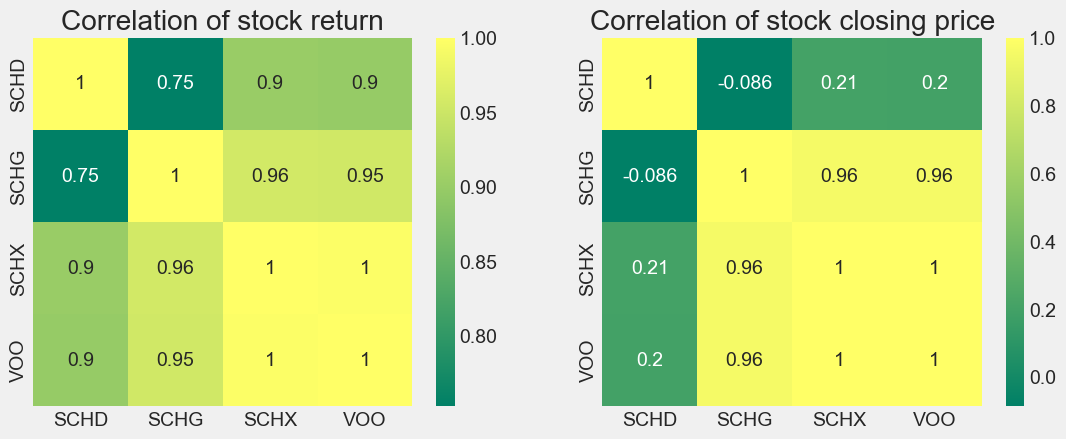

In [18]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pct_change_1.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

# 5. How much value do we put at risk by investing in a particular stock?

There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

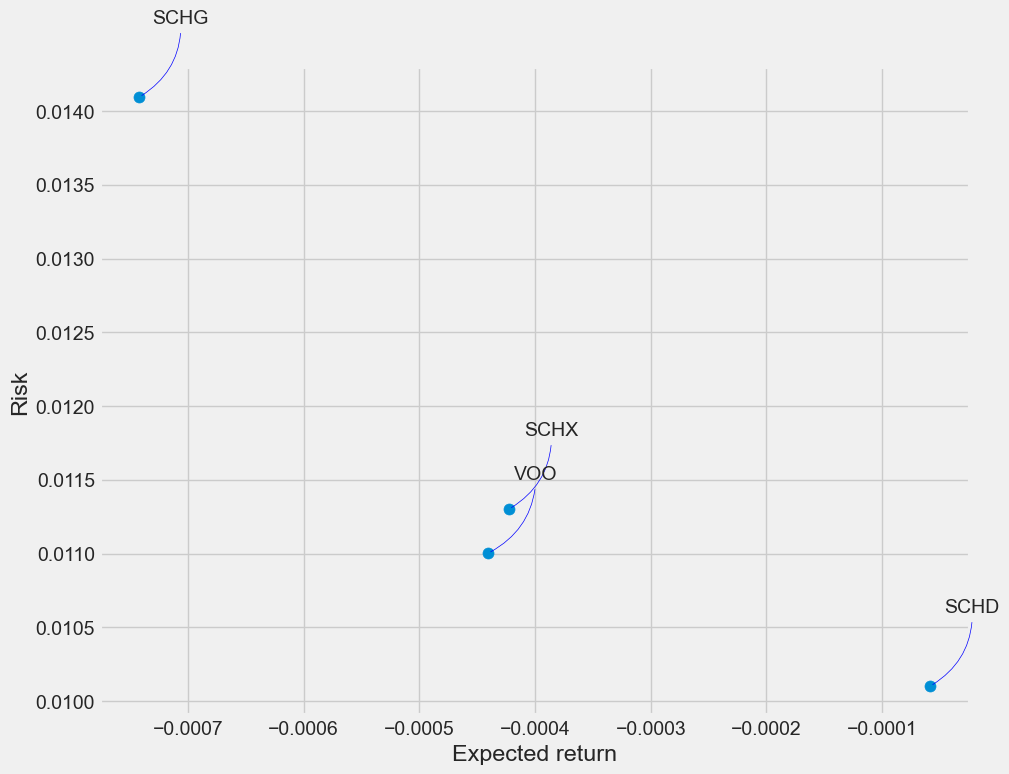

In [19]:
area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(pct_change_1.mean(), pct_change_1.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(pct_change_1.columns, pct_change_1.mean(), pct_change_1.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))